![MLU Logo](../data/MLU_Logo.png)

# <a name="0">Machine Learning Accelerator - Computer Vision - Lecture 1</a>

## Neural Networks with PyTorch

In this notebook, we build, train and validate a Neural Network using PyTorch, a popular deep learning framework that provides a clear, concise, and simple API for deep learning. 

1. <a href="#1">Implementing a neural network with PyTorch</a>       
2. <a href="#2">Loss Functions</a>
3. <a href="#3">Training</a>
4. <a href="#4">Example - Binary Classification</a>
    

In [1]:
! pip install -q -r ../requirements.txt

## 1. <a name="1">Implementing a neural network with PyTorch</a>
(<a href="#0">Go to top</a>)

Let's implement a simple neural network with two hidden layers of size 64 using the sequential model. We will have 3 inputs, 2 hidden layers and 1 output layer. Some drop-outs attached to the hidden layers.

In [2]:
import torch
import torch.nn as nn

net = nn.Sequential(
    nn.Linear(3, 64),                # Linear layer-1 with 64 units
    nn.Tanh(),                       # Tanh activation is applied
    nn.Dropout(0.4),                 # Apply random 40% drop-out to layer_1
    
    nn.Linear(64, 64),               # Linear layer-2 with 64 units  
    nn.Tanh(),                       # Tanh activation is applied
    nn.Dropout(0.3),                 # Apply random 30% drop-out to layer_2
    
    nn.Linear(64, 1)                 # Output layer with single unit
)

print(net)

Sequential(
  (0): Linear(in_features=3, out_features=64, bias=True)
  (1): Tanh()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): Tanh()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=64, out_features=1, bias=True)
)


We first randomly initialize the weights parameters of the network. Using these weights as a start, we can later apply optimization such as SGD to train the weights. As a result, using a strategic technique to initialize the weights is crucial. 

PyTorch automatically initializes the weights, but we can use custom initialization if needed. Here, we'll use Xavier initialization, which can keep the scale of gradients roughly the same in all the layers.

In [3]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

net.apply(init_weights)

Sequential(
  (0): Linear(in_features=3, out_features=64, bias=True)
  (1): Tanh()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): Tanh()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=64, out_features=1, bias=True)
)

We can easily access the layers with `net[layer_index]`:

In [4]:
print(net[0])
print(net[1])
print(net[2])
print(net[3])
print(net[4])

Linear(in_features=3, out_features=64, bias=True)
Tanh()
Dropout(p=0.4, inplace=False)
Linear(in_features=64, out_features=64, bias=True)
Tanh()


## 2. <a name="2">Loss Functions</a>
(<a href="#0">Go to top</a>)

We can select loss functions according to our problem. PyTorch provides a variety of loss functions. 

Let's go over some popular loss functions and see how to call a built-in loss function:


__Binary Cross-entropy Loss:__ A common used loss function for binary classification. 

```python
loss = nn.BCELoss()
```

__Categorical Cross-entropy Loss:__ A common used loss function for multi-class classification. 

```python
loss = nn.CrossEntropyLoss()
```

__Mean Squared Error Loss:__ A most common used loss function for regression problems. 

```python
loss = nn.MSELoss()
```

## 3. <a name="3">Training</a>
(<a href="#0">Go to top</a>)

PyTorch's `torch.optim` module provides necessary training algorithms for neural networks. We can use the following optimizer to train a network using Stochastic Gradient Descent (SGD) method and learning rate of 0.001.

```python
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001)
```

## 4. <a name="4">Example - Binary Classification</a>
(<a href="#0">Go to top</a>)

In this example, we will train a neural network on a dataset that we randomly generated. We will have two classes and train a neural network to classify them.

In [5]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=750, shuffle=True, random_state=42, noise=0.05, factor=0.3)

First let's plot the simulated dataset.

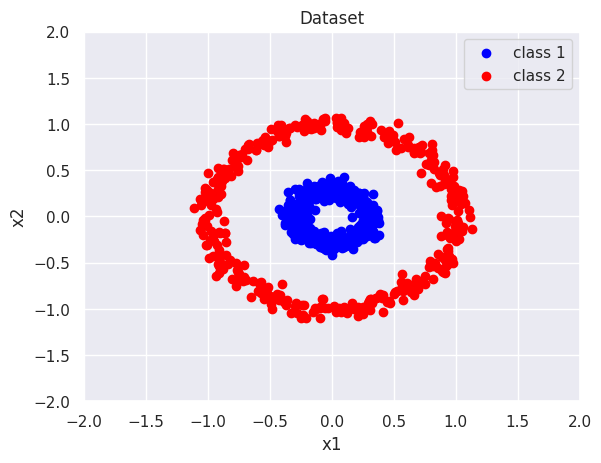

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dataset(X, y, title):
    
    # Activate Seaborn visualization
    sns.set()
    
    # Plot both classes: Class1->Blue, Class2->Red
    plt.scatter(X[y==1, 0], X[y==1, 1], c='blue', label="class 1")
    plt.scatter(X[y==0, 0], X[y==0, 1], c='red', label="class 2")
    plt.legend(loc='upper right')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.title(title)
    plt.show()
    
plot_dataset(X, y, title="Dataset")

Next, we import the necessary libraries and classes.

In [7]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

Then, we create the network as below. It will have two hidden layers. Since the data seems easily seperable, we can have a small network (2 hidden layers) with 10 units at each layer.

In [8]:
net = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid()
)

net.apply(init_weights)

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
  (5): Sigmoid()
)

Now let's prepare the training set and validation set, and load each of them to a `DataLoader`, respectively.

In [9]:
# Split the dataset into two parts: 80%-20% split
X_train, X_val = X[:int(len(X)*0.8), :], X[int(len(X)*0.8):, :]
y_train, y_val = y[:int(len(X)*0.8)], y[int(len(X)*0.8):]

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).unsqueeze(1)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val).unsqueeze(1)

# Use PyTorch DataLoaders to load the data in batches
batch_size = 4           # How many samples to use for each weight update 
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Before the training, one last thing is to define the hyper-parameters for training.

In [10]:
epochs = 50              # Total number of iterations
learning_rate = 0.01     # Learning rate

# Define the loss
criterion = nn.BCELoss()

# Define the optimizer, SGD with learning rate
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

Finally, it is the time for training! We will run through the training set 50 times (i.e., epochs) and print training and validation losses at each epoch.

In [11]:
import time

train_losses = []
val_losses = []
for epoch in range(epochs):
    start = time.time()
    training_loss = 0
    # Build a training loop, to train the network
    net.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        training_loss += loss.item() * data.size(0)
    
    # Get validation predictions
    net.eval()
    with torch.no_grad():
        val_predictions = net(X_val)
        val_loss = criterion(val_predictions, y_val)
    
    # Take the average losses
    training_loss = training_loss / len(y_train)
    val_loss = val_loss.item()
    
    train_losses.append(training_loss)
    val_losses.append(val_loss)
    
    end = time.time()
    # Print the losses every 10 epochs
    if (epoch == 0) or ((epoch+1)%10 == 0):
        print(f"Epoch {epoch}. Train_loss {training_loss:.6f} Validation_loss {val_loss:.6f} Seconds {end-start:.6f}")

Epoch 0. Train_loss 0.700956 Validation_loss 0.690042 Seconds 0.140385
Epoch 9. Train_loss 0.434906 Validation_loss 0.398907 Seconds 0.121655
Epoch 19. Train_loss 0.068839 Validation_loss 0.064943 Seconds 0.120567
Epoch 29. Train_loss 0.021281 Validation_loss 0.021616 Seconds 0.119825
Epoch 39. Train_loss 0.010870 Validation_loss 0.011507 Seconds 0.118245
Epoch 49. Train_loss 0.006934 Validation_loss 0.007558 Seconds 0.119597


Let's see the training and validation loss plots below. Losses go down as the training process continues as expected.

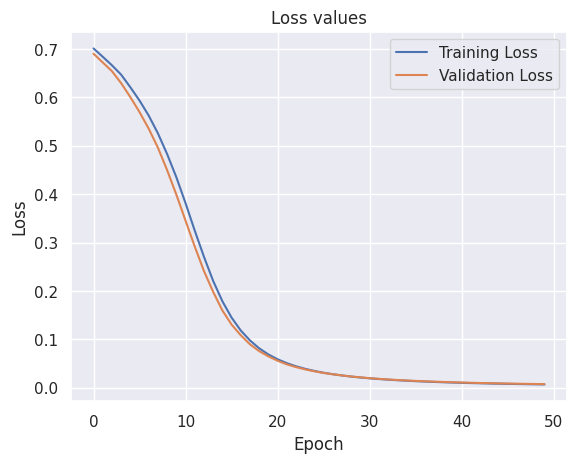

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()